In [306]:
import pandas as pd
import numpy as np
import pyreadstat as prs
import os
from pathlib import Path

In [307]:
path_spss = Path("/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/Long-run dynamics of wealth inequalities/Paper/Data/CBOS SPSS")
list_dir = os.listdir(path_spss)
list_dir = [file for file in list_dir if file.endswith(".sav")]

# Sort by CBOS_XXX where XXX is a number with 1 to 3 digits
list_dir.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

In [308]:
# Load the relevant questions summary
questions_summary = pd.read_csv(Path("/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/Long-run dynamics of wealth inequalities/Paper/local_repo/LRDWI-Paper/relevant_questions_summary.csv"))

# Sort by "spss_file" using the same logic as above
questions_summary['spss_file'] = questions_summary['spss_file'].astype(str)
questions_summary = questions_summary.sort_values(by='spss_file', key=lambda x: x.str.split('_').str[1].str.split('.').str[0].astype(int))

In [309]:
spss_files = questions_summary['spss_file'].unique()
for file in spss_files:
    file_summary = questions_summary[questions_summary['spss_file'] == file]
    if "income_household_per_person" not in file_summary['relevant_key'].values:
        print(file)
    else:
        print(file_summary['matched_question'].values["income_household_per_person" == file_summary['relevant_key'].values])

['Ile wynoszą W STARYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? [tysiące starych złotych]']
['Ile wynoszą W STARYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? [tysiące starych złotych]'
 'Ile wynoszą W STARYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? [tysiące starych złotych]']
CBOS_3_03_1990.sav
CBOS_4_04_1990.sav
CBOS_5_05_1990.sav
CBOS_6_06_1990.sav
CBOS_7_07_1990.sav
CBOS_8_09_1990.sav
CBOS_9_10_1990.sav
CBOS_10_11_1990.sav
CBOS_11_12_1990.sav
CBOS_12_01_1991.sav
CBOS_13_02_1991.sav
CBOS_14_03_1991.sav
CBOS_15_04_1991.sav
CBOS_16_05_1991.sav
CBOS_17_06_1991.sav
CBOS_18_07_1991.sav
CBOS_19_08_1991.sav
CBOS_20_09_1991.sav
CBOS_21_10_1991.sav
CBOS_22_11_1991.sav
CBOS_23_01_1992.sav
['Ile wynoszą W STARYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? [tysiące starych złotych]']
['Ile wynoszą W NOWYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodar- stwie domowym? 

In [310]:
v_lower = np.vectorize(lambda x: x.lower() if isinstance(x, str) else x)
v_compare = np.vectorize(lambda x, y: x == y)
v_contains = np.vectorize(lambda x, y: y in x if isinstance(x, str) and isinstance(y, str) else False)

In [ ]:
main_df = pd.DataFrame()

old_age_col = None
old_gender_col = None
old_city_size_col = None
old_location_col = None

for file in list_dir:
    # Load SPSS file
    df, meta = prs.read_sav(path_spss / file)
    
    # Sub df
    df_sub = pd.DataFrame()
    
    # Add meta info
    df_sub['org_id'] = df[df.columns[0]]
    df_sub['survey file'] = file
    df_sub['survey year'] = int(file[-8:-4])
    df_sub['survey month'] = int(file[-11:-9])
    df_sub['age'] = 0
    
    # Get demographics
    
    col_names = meta.column_names
    col_names = v_lower(col_names)
    
    # Look for age column
    age_col = np.where(v_compare(col_names, 'urodzony'))[0]
    
    # Look for gender column
    gender_col = np.where(v_compare(col_names, 'plec'))[0]
    
    # Look for city size column
    city_size_col = np.where(v_contains(col_names, 'klm'))[0]
    
    # Look for education level column
    education_col = np.where(v_contains(col_names, 'wyksztalcenie'))[0]
    
    # Look for location column
    location_col = np.where(v_contains(col_names, 'woj'))[0]
    
    # Check with relevalnt questions summary
    relevant_questions = questions_summary[questions_summary['spss_file'] == file]
    
    # AGE
    if len(age_col) > 0:
        age_col_name = meta.column_names[age_col[0]]
        df_sub['year_born'] = df[age_col_name]
    else:
        age_col_rq = relevant_questions['relevant_key'] == 'age'
        age_col_rq = relevant_questions[age_col_rq]
        if len(age_col_rq) == 1:
            age_col = np.where(col_names == v_lower(age_col_rq['column_name'].values))[0]            
            age_col_name = meta.column_names[age_col[0]]
            df_sub['year_born'] = df[age_col_name]
        elif len(age_col_rq) > 1:
            age_col_names = age_col_rq['column_name'].values
            age_col_name = age_col_names[1] 
            age_col = np.where(col_names == v_lower(age_col_name))[0]
            age_col_name = meta.column_names[age_col[0]]
            df_sub['year_born'] = df[age_col_name]
        else:
            col_labels = meta.column_labels
            col_labels = v_lower(col_labels)
            age_col = np.where(v_compare(col_labels, 'm2 rok'))[0]
            if len(age_col) == 0:
                age_col = np.where(v_contains(col_labels, '- rok'))[0]
            if len(age_col) == 0:
                age_col = np.where(v_contains(col_labels, 'urodził(a)'))[0]
            if len(age_col) == 0:
                age_col = np.where(v_contains(col_labels, 'rok urodzenia respondenta'))[0]
            age_col_name = meta.column_names[age_col[0]]
            df_sub['year_born'] = df[age_col_name]
    
    # GENDER
    if len(gender_col) > 0:
        gender_col_name = meta.column_names[gender_col[0]]
        df_sub['sex'] = df[gender_col_name]
    else:
        gender_col_rq = relevant_questions['relevant_key'] == 'gender'
        gender_col_rq = relevant_questions[gender_col_rq]
        if len(gender_col_rq) == 1:
            gender_col = np.where(col_names == v_lower(gender_col_rq['column_name'].values))[0]
            gender_col_name = meta.column_names[gender_col[0]]
            df_sub['sex'] = df[gender_col_name]
        else:
            col_labels = meta.column_labels
            col_labels = v_lower(col_labels)
            gender_col = np.where(v_contains(col_labels, 'm1.'))[0]
            if len(gender_col) == 0 or (len(gender_col) > 0 and "płeć" not in col_labels[gender_col[0]]):
                gender_col = np.where(v_contains(col_labels, 'płeć'))[0]
            if len(gender_col) == 0:
                gender_col = np.where(v_contains(col_labels, 'płęć'))[0]
            if len(gender_col) > 1:
                print(f"Warning: multiple gender columns found in {file}.")
            gender_col_name = meta.column_names[gender_col[0]]
            if file == "CBOS_203_04_2007.sav":
                gender_col_name = "M1PLEC"
            df_sub['sex'] = df[gender_col_name]
            
    # Map gender labels
    gender_labels_dict = meta.value_labels[meta.variable_to_label[gender_col_name]]
    df_sub['sex_L'] = ''
    for key, value in gender_labels_dict.items():
        df_sub.loc[df_sub['sex'] == key, 'sex_L'] = value
    
    # CITY SIZE
    if len(city_size_col) > 0:
        city_size_col_name = meta.column_names[city_size_col[0]]
        df_sub['city_size'] = df[city_size_col_name]
    else:
        city_size_col_rq = relevant_questions['relevant_key'] == 'city_size'
        city_size_col_rq = relevant_questions[city_size_col_rq]
        if len(city_size_col_rq) == 1:
            city_size_col = np.where(col_names == v_lower(city_size_col_rq['column_name'].values))[0]
            city_size_col_name = meta.column_names[city_size_col[0]]
            df_sub['city_size'] = df[city_size_col_name]
        else:
            col_labels = meta.column_labels
            col_labels = v_lower(col_labels)
            city_size_col = np.where(v_contains(col_labels, 'czy miejscowość'))[0]
            if len(city_size_col) == 0:
                city_size_col = np.where(v_contains(col_labels, 'miejscowość'))[0]
            if "221_10_2008" in file:
                city_size_col_name = 'q7'
            elif "266_07_2012" in file or "268_09_2012" in file:
                city_size_col_name = ''
            else:
                city_size_col_name = meta.column_names[city_size_col[0]]
                
            if len(city_size_col) > 1:
                print(f"Warning: multiple city size columns found in {file}.")
                
            if city_size_col_name != '':
                df_sub['city_size'] = df[city_size_col_name]
            else:
                df_sub['city_size'] = np.nan
    
    # Map city size labels
    if city_size_col_name != '':
        city_size_labels_dict = meta.value_labels[meta.variable_to_label[city_size_col_name]]
        df_sub['city_size_L'] = ''
        for key, value in city_size_labels_dict.items():
            df_sub.loc[df_sub['city_size'] == key, 'city_size_L'] = value
    else:
        df_sub['city_size_L'] = np.nan
    
    # EDUCATION LEVEL
    if len(education_col) > 0:
        education_col_name = meta.column_names[education_col[0]]
        df_sub['education'] = df[education_col_name]
    else:
        education_col_rq = relevant_questions['relevant_key'] == 'education'
        education_col_rq = relevant_questions[education_col_rq]
        if len(education_col_rq) == 1:
            education_col = np.where(col_names == v_lower(education_col_rq['column_name'].values))[0]
            education_col_name = meta.column_names[education_col[0]]
            df_sub['education'] = df[education_col_name]
        else:
            col_labels = meta.column_labels
            col_labels = v_lower(col_labels)
            education_col = np.where(v_contains(col_labels, 'm3.'))[0]
            if len(education_col) == 0 or (len(education_col) > 0 and "wykształcenie" not in col_labels[education_col[0]]):
                education_col = np.where(v_contains(col_labels, 'm6.'))[0]
            if len(education_col) == 0 or (len(education_col) > 0 and "wykształcenie" not in col_labels[education_col[0]]):
                education_col = np.where(v_contains(col_labels, 'wykształcenie'))[0]
            if len(education_col) == 0 or ("10_2013" in file) or ("11_2013" in file):
                education_col = np.where(v_contains(col_labels, 'poziom wykształcenia'))[0]
            if len(education_col) > 1:
                print(f"Warning: multiple education level columns found in {file}.")
            education_col_name = meta.column_names[education_col[0]]
            df_sub['education'] = df[education_col_name]
    
    # Map education level labels
    education_labels_dict = meta.value_labels[meta.variable_to_label[education_col_name]]
    df_sub['education_L'] = ''
    for key, value in education_labels_dict.items():
        df_sub.loc[df_sub['education'] == key, 'education_L'] = value
    
    # LOCATION
    df_sub['location_new'] = 0
    df_sub['location_old'] = 0
    df_sub['location_new_L'] = ''
    df_sub['location_old_L'] = ''
    
    col_labels = meta.column_labels
    col_labels = v_lower(col_labels)
    location_col = np.where(v_compare(col_labels, 'województwo'))[0]
    if len(location_col) != 1:
        location_col = np.where(v_contains(col_labels, 'województwo'))[0]
    if len(location_col) == 1:
        location_col_name = meta.column_names[location_col[0]]
        if df_sub['survey year'].values[0] < 1999:
            df_sub['location_old'] = df[location_col_name]
            location_labels_dict = meta.value_labels[meta.variable_to_label[location_col_name]]
            for key, value in location_labels_dict.items():
                df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
        else:
            df_sub['location_new'] = df[location_col_name]
            if "140_01_2002" not in file:
                location_labels_dict = meta.value_labels[meta.variable_to_label[location_col_name]]
            for key, value in location_labels_dict.items():
                df_sub.loc[df_sub['location_new'] == key, 'location_new_L'] = value
    else:
        if len(location_col) == 0:
            location_col = np.where(v_contains(col_labels, 'województwa'))[0]
            if len(location_col) == 0:
                location_col = np.where(v_contains(col_labels, 'aneks woj'))[0]
            if len(location_col) == 0:
                location_col = np.where(v_contains(col_labels, 'wojewodztwo'))[0]
            if len(location_col) == 0:
                location_col = np.where(v_compare(col_labels, 'woj.nowe'))[0]
            if len(location_col) == 0:
                location_col = np.where(v_compare(col_labels, 'makroregion'))[0]
            
            if len(location_col) == 1:
                location_col_name = meta.column_names[location_col[0]]
                if df_sub['survey year'].values[0] < 1999:
                    df_sub['location_old'] = df[location_col_name]
                    location_labels_dict = meta.value_labels[meta.variable_to_label[location_col_name]]
                    for key, value in location_labels_dict.items():
                        df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
                else:
                    location_labels_dict = meta.value_labels[meta.variable_to_label[location_col_name]]
                    if len(location_labels_dict) > 20:
                        df_sub['location_old'] = df[location_col_name]
                        for key, value in location_labels_dict.items():
                            df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
                    else:
                        df_sub['location_new'] = df[location_col_name]
                        for key, value in location_labels_dict.items():
                            df_sub.loc[df_sub['location_new'] == key, 'location_new_L'] = value
            else:
                location_col_names = [meta.column_labels[i] for i in location_col]
                location_old_col_name = np.where(v_contains(v_lower(location_col_names), 'stare'))[0]
                location_new_col_name = np.where(v_contains(v_lower(location_col_names), 'nowe'))[0]
                location_old_col = np.where(v_compare(location_col, location_col[location_old_col_name[0]]))[0]
                location_new_col = np.where(v_compare(location_col, location_col[location_new_col_name[0]]))[0]
                
                df_sub['location_old'] = df[meta.column_names[location_col[location_old_col[0]]]]
                location_labels_dict_old = meta.value_labels[meta.variable_to_label[meta.column_names[location_col[location_old_col[0]]]]]
                for key, value in location_labels_dict_old.items():
                    df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
                df_sub['location_new'] = df[meta.column_names[location_col[location_new_col[0]]]]
                location_labels_dict_new = meta.value_labels[meta.variable_to_label[meta.column_names[location_col[location_new_col[0]]]]]
                for key, value in location_labels_dict_new.items():
                    df_sub.loc[df_sub['location_new'] == key, 'location_new_L'] = value
        else:
            location_col_names = [meta.column_labels[i] for i in location_col]
            location_old_col_name = np.where(v_contains(v_lower(location_col_names), 'stare'))[0]
            location_new_col_name = np.where(v_contains(v_lower(location_col_names), 'nowe'))[0]
            location_old_col = np.where(v_compare(location_col, location_col[location_old_col_name[0]]))[0]
            location_new_col = np.where(v_compare(location_col, location_col[location_new_col_name[0]]))[0]
            
            df_sub['location_old'] = df[meta.column_names[location_col[location_old_col[0]]]]
            location_labels_dict_old = meta.value_labels[meta.variable_to_label[meta.column_names[location_col[location_old_col[0]]]]]
            for key, value in location_labels_dict_old.items():
                df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
            df_sub['location_new'] = df[meta.column_names[location_col[location_new_col[0]]]]
            location_labels_dict_new = meta.value_labels[meta.variable_to_label[meta.column_names[location_col[location_new_col[0]]]]]
            for key, value in location_labels_dict_new.items():
                df_sub.loc[df_sub['location_new'] == key, 'location_new_L'] = value
    
    # HH SIZE
    hh_size_col = relevant_questions['relevant_key'] == 'household_size'
    hh_size_col = relevant_questions[hh_size_col]
    hh_size_col_name = hh_size_col['column_name'].values
    if len(hh_size_col_name) == 0:
        col_labels = meta.column_labels
        col_labels = v_lower(col_labels)
        #print(col_labels)
        hh_size_col = np.where(v_contains(col_labels, 'z ilu osób'))[0]
        if len(hh_size_col) > 0:
            hh_size_col_name = meta.column_names[hh_size_col[0]]
            df_sub['household_size'] = df[hh_size_col_name]
        else:
            df_sub['household_size'] = np.nan
            print(f"Warning: household size column not found in {file}.")
    elif len(hh_size_col_name) > 1 and "281_10_2013" in file:
        hh_size_col_name = hh_size_col_name[1]
        df_sub['household_size'] = df[hh_size_col_name]
    elif len(hh_size_col_name) > 2 and "282_11_2013" in file:
        hh_size_col_name = hh_size_col_name[2]
        df_sub['household_size'] = df[hh_size_col_name]
    else:
        df_sub['household_size'] = df[hh_size_col_name]
    
    
    # HH INCOME
    df_sub['income_household_per_person'] = 0
    df_sub['income_household_per_person_T'] = 0
    df_sub['income_household_per_person_L'] = 0
    df_sub['income_household_per_person_T_L'] = 0
    
    col_labels = meta.column_labels
    col_labels = v_lower(col_labels)
    income_col = np.where(v_contains(col_labels, 'dochody'))[0]
    if len(income_col) == 1:
        income_col_name = meta.column_names[income_col[0]]
        values = df[income_col_name].values
        
        if np.max(values) > 100:
            df_sub['income_household_per_person'] = df[income_col_name]
            try:
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_household_per_person'] == key, 'income_household_per_person_L'] = value
            except KeyError:
                pass
        else:
            df_sub['income_household_per_person_T'] = df[income_col_name]
            income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
            for key, value in income_labels_dict.items():
                df_sub.loc[df_sub['income_household_per_person_T'] == key, 'income_household_per_person_T_L'] = value
            
    elif len(income_col) > 1:
        col_labels_income = [meta.column_labels[i] for i in income_col]
        income_hh_col = np.where(v_contains(v_lower(col_labels_income), 'osobę'))[0]
        if len(income_hh_col) > 0:
            print(f"Multiple income columns found in {file}")
            labels = [meta.column_labels[income_col[i]] for i in income_hh_col]
            print(len(labels))
            for i, label in zip(income_hh_col, labels):
                print(f"  - {i}: {label}")
    else:
        print(f"Warning: income column not found in {file}.")
        
    main_df = pd.concat([main_df, df_sub], ignore_index=True)
    
    '''
    # Get relevant questions for this file
    relevant_questions = questions_summary[questions_summary['spss_file'] == file]['relevant_key'].values[0].split(';')
    
    # Select only relevant columns
    df_relevant = df[relevant_questions]
    
    # Add a column for the survey wave
    survey_wave = int(file.split('_')[1].split('.')[0])
    df_relevant['survey_wave'] = survey_wave
    
    # Append to main dataframe
    main_df = pd.concat([main_df, df_relevant], ignore_index=True)
    '''

Multiple income columns found in CBOS_26_07_1992.sav
1
  - 1: M12. Ile wynoszą miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? Proszę wziąć pod uwagę dochody z pracy głównej wraz z premiami, (..) wszystkich członków Pana(i) gd. i obliczyć średnią za ostatnie 3 miesiące.
Multiple income columns found in CBOS_27_09_1992.sav
4
  - 0: P9. Ile, według Pana(i), powinny wynosić miesięczne dochody na jedną osobę w Pana(i) rodzinie, aby można było: - żyć dostatnio, bez problemów finansowych
  - 1: P9. Ile, według Pana(i), powinny wynosić miesięczne dochody na jedną osobę w Pana(i) rodzinie, aby można było: - żyć na średnim poziomie
  - 2: P9. Ile, według Pana(i), powinny wynosić miesięczne dochody na jedną osobę w Pana(i) rodzinie, aby można było: - zaspokajać jedynie podstawowe potrzeby
  - 3: M12. Ile wynoszą miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? Proszę wziąć pod uwagę dochody z pracy głównej wraz z premiami, (..) wszystkich członków Pana(i) gd. i oblic

In [300]:
meta.creation_time

datetime.datetime(2021, 8, 30, 19, 0, 23)

In [316]:
main_df

,org_id,survey file,survey year,survey month,age,year_born,sex,sex_L,city_size,city_size_L,education,education_L,location_new,location_old,location_new_L,location_old_L,household_size,income_household_per_person
0,1.0,CBOS_1_01_1990.sav,1990,1,0,1957.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,8.0,Niepełne wyższe,0.0,1.0,,Warszawskie,4.0,NaN
1,2.0,CBOS_1_01_1990.sav,1990,1,0,1950.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,9.0,Wyższe,0.0,1.0,,Warszawskie,2.0,NaN
2,3.0,CBOS_1_01_1990.sav,1990,1,0,1932.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,2.0,Podstawowe ukończone,0.0,5.0,,Bydgoskie,2.0,NaN
3,4.0,CBOS_1_01_1990.sav,1990,1,0,1946.0,1.0,Mężczyzna,9.0,Miasto powyżej 500 tys. mieszkańców,3.0,Zasadnicze zawodowe,0.0,5.0,,Bydgoskie,4.0,NaN
4,5.0,CBOS_1_01_1990.sav,1990,1,0,1939.0,1.0,Mężczyzna,9.0,Miasto powyżej 500 tys. mieszkańców,9.0,Wyższe,0.0,NaN,,,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358520,921.0,CBOS_331_12_2017.sav,2017,12,0,1957.0,1.0,Mężczyzna,1.0,wieś,8.0,"Średnie zawodowe z maturą (technikum, liceum z...",2.0,0.0,Południowy,,2.0,NaN
358521,922.0,CBOS_331_12_2017.sav,2017,12,0,1981.0,1.0,Mężczyzna,1.0,wieś,8.0,"Średnie zawodowe z maturą (technikum, liceum z...",2.0,0.0,Południowy,,4.0,NaN
358522,923.0,CBOS_331_12_2017.sav,2017,12,0,1976.0,1.0,Mężczyzna,5.0,miasto od 100 000 do 499 999,8.0,"Średnie zawodowe z maturą (technikum, liceum z...",2.0,0.0,Południowy,,3.0,NaN
358523,924.0,CBOS_331_12_2017.sav,2017,12,0,1971.0,2.0,Kobieta,5.0,miasto od 100 000 do 499 999,4.0,Zasadnicze zawodowe (także SPR),2.0,0.0,Południowy,,4.0,NaN


In [129]:
meta.variable_to_label

{'plec': 'labels0',
 'klm6': 'labels1',
 'q10': 'labels2',
 'q11': 'labels3',
 'q12': 'labels4',
 'q13': 'labels5',
 'q14': 'labels6',
 'q15': 'labels7',
 'q20s1': 'labels8',
 'q20s2': 'labels9',
 'q21': 'labels10',
 'q24': 'labels11',
 'q25': 'labels12',
 'q26s1': 'labels13',
 'q26s2': 'labels14',
 'q26s3': 'labels15',
 'q27s1': 'labels16',
 'q27s2': 'labels17',
 'q27s3': 'labels18',
 'q28': 'labels19',
 'q29': 'labels20',
 'q30': 'labels21',
 'q31': 'labels22',
 'q32': 'labels23',
 'q33': 'labels24',
 'q34': 'labels25',
 'q43': 'labels26',
 'q44': 'labels27',
 'q45': 'labels28',
 'q46': 'labels29',
 'L1q48': 'labels30',
 'L2q48': 'labels31',
 'L3q48': 'labels32',
 'L4q48': 'labels33',
 'L1q51': 'labels34',
 'L2q51': 'labels34',
 'L3q51': 'labels34',
 'L4q51': 'labels34',
 'L5q51': 'labels34',
 'L6q51': 'labels34',
 'L7q51': 'labels34',
 'L8q51': 'labels34',
 'L9q51': 'labels34',
 'L10q51': 'labels34',
 'L11q51': 'labels34',
 'L12q51': 'labels34',
 'L13q51': 'labels34',
 'L14q51': 'la

In [120]:
meta.value_labels

{'labels0': {1.0: 'Mężczyzna', 2.0: 'Kobieta'},
 'labels1': {1.0: 'wieś',
  2.0: 'miasto do 19 999',
  3.0: 'miasto od 20 000 do 49 999',
  4.0: 'miasto od 50 000 do 99 999',
  5.0: 'miasto od 100 000 do 499 999',
  6.0: 'miasto 500 000 i więcej'},
 'labels2': {1.0: 'Tak, w pełnym wymiarze czasu',
  2.0: 'Tak, w niepełnym wymiarze czasu',
  3.0: 'Tak, dorywczo',
  4.0: 'Nie'},
 'labels3': {-1.0: 'ND: q10 (M1) = 4',
  1.0: 'w instytucji, urzędzie lub zakładzie całkowicie państwowym, samorządowym  lub publicznym (także w jednoosobowej spółc...',
  2.0: 'w spółce z udziałem właścicieli prywatnych (polskich lub zagranicznych) i państwa',
  3.0: 'w zakładzie (spółce) całkowicie prywatnym poza rolnictwem lub w spółdzielni (dotyczy także właścicieli lub współwłaśc...',
  4.0: 'w prywatnym gospodarstwie rolnym'},
 'labels4': {1.0: 'Dyrektorzy, prezesi i kadra kierownicza przedsiębiorstw, instytucji oraz administracji państwowej i samorządowej',
  2.0: 'Zawody twórcze i specjaliści z wyższym wy

In [ ]:
for file in list_dir:
    keys = questions_summary[questions_summary['spss_file'] == file]['relevant_key'].tolist()
    print(f"File: {file}, Relevant Keys:")
    if "age" in keys:
        print(" - age")
    if "location" in keys:
        print(" - location")
    if "education" in keys:
        print(" - education")
    if "income_household_per_person" in keys:
        print(" - income_household_per_person")
    if "household_size" in keys:
        print(" - household_size")
    
    
    print("Other relevant questions:")
    for key in keys:
        if key not in ["age", "location", "education", "income_household_per_person", "household_size"]:
            print(f" - {key}")
    print("\n")        

File: CBOS_1_01_1990.sav, Relevant Keys:
 - age
 - education
 - income_household_per_person
 - household_size
Other relevant questions:
 - city_size


File: CBOS_2_02_1990.sav, Relevant Keys:
 - age
 - education
 - income_household_per_person
 - household_size
Other relevant questions:
 - city_size


File: CBOS_3_03_1990.sav, Relevant Keys:
 - age
 - education
Other relevant questions:
 - city_size
 - marital


File: CBOS_4_04_1990.sav, Relevant Keys:
 - age
 - education
Other relevant questions:
 - if_investing
 - city_size
 - marital


File: CBOS_5_05_1990.sav, Relevant Keys:
 - age
 - education
 - household_size
Other relevant questions:
 - marital
 - city_size


File: CBOS_6_06_1990.sav, Relevant Keys:
 - age
 - education
 - household_size
Other relevant questions:
 - marital
 - city_size


File: CBOS_7_07_1990.sav, Relevant Keys:
 - age
 - education
 - household_size
Other relevant questions:
 - city_size
 - marital
 - city_size


File: CBOS_8_09_1990.sav, Relevant Keys:
 - age
 -

In [326]:
list_dir[84]

'CBOS_87_08_1997.sav'

In [324]:
# Load first SPSS file to test
df, meta = prs.read_sav(path_spss / list_dir[84])

meta.column_names_to_labels

{'r1': 'Numer kolejny rekordu',
 'PADS_ID': 'Identyfikator PADS',
 'DOI': 'Identyfikator DOI',
 'Today': 'Data końca pracy',
 'q489': 'GODZINA ROZPOCZĘCIA WYWIADU',
 'q490': 'MINUTA ROZPOCZĘCIA WYWIADU',
 'q13': 'P1. Czy, ogólnie rzecz biorąc, sytuacja w naszym kraju zmierza w dobrym czy też w złym kierunku?',
 'q14': 'P2. A jak Pan(i) sądzi, czy w ciągu najbliższego roku sytuacja w Polsce poprawi się, pogorszy czy też się nie zmieni?',
 'q15': 'P3. Jak Pan(i) ogólnie ocenia obecną ...  w Polsce? Czy jest ona: - sytuację polityczną',
 'q16': 'P3. Jak Pan(i) ogólnie ocenia obecną ...  w Polsce? Czy jest ona: - sytuację gospodarczą',
 'q17': 'P3. Jak Pan(i) ogólnie ocenia obecną ...  w Polsce? Czy jest ona: - sytuację w Pana(i) zakładzie pracy',
 'q18': 'P4. Czy, Pana(i) zdaniem, w ciągu najbliższego roku ...  w Polsce: - sytuacja polityczna',
 'q19': 'P4. Czy, Pana(i) zdaniem, w ciągu najbliższego roku ...  w Polsce: - sytuacja gospodarcza',
 'q20': 'P4. Czy, Pana(i) zdaniem, w ciągu na

In [342]:
inc = df['q408'].values* df['q410'].values

In [343]:
inc = np.sort(inc)

# Remove missing values
inc = inc[~np.isnan(inc)]

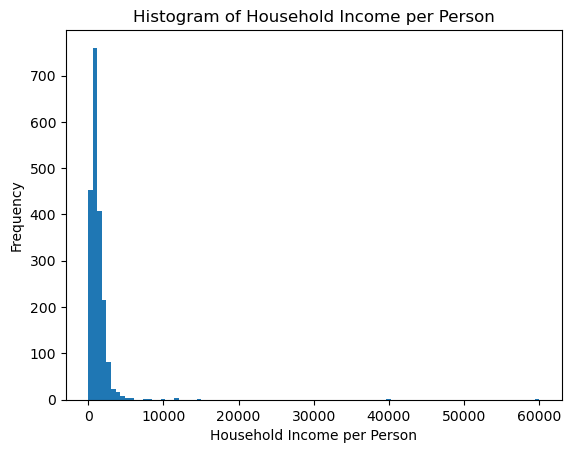

np.float64(0.36837078665378503)

In [345]:
# Hisotogram form inc
import matplotlib.pyplot as plt
plt.hist(inc, bins=100)
plt.xlabel('Household Income per Person')
plt.ylabel('Frequency')
plt.title('Histogram of Household Income per Person')
plt.show()

# Gini coefficient
def gini_coefficient(x):
    n = len(x)
    if n == 0:
        return np.nan
    cumulative_x = np.cumsum(np.sort(x))
    sum_x = cumulative_x[-1]
    if sum_x == 0:
        return 0.0
    gini = (n + 1 - 2 * np.sum(cumulative_x) / sum_x) / n
    return gini

gini_coefficient(inc)